In [1]:
! mkdir .kaggle 
! mv kaggle.json .kaggle
! ls -a .kaggle

.  ..  kaggle.json


In [2]:
! mv .kaggle ~/.

In [3]:
! ls -a ~/.

.   .bashrc  .config   .jupyter  .keras  .npm	   .tmux.conf
..  .cache   .ipython  .kaggle	 .local  .profile  .wget-hsts


In [ ]:
! kaggle datasets download -d jangedoo/utkface-new
! unzip utkface-new.zip

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [6]:
width = height =  175
batch_size = 32

In [7]:
images = []  #X
ages = []    #Y

for image_name in os.listdir('/content/UTKFace'):
  age = int(image_name.split('_')[0])
  ages.append(age)

  image = cv2.imread(f"/content/UTKFace/{image_name}")
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(width,height))
  images.append(image)

In [8]:
images = pd.Series(images,name='Images') # covenrt list of python to series
ages = pd.Series(ages,name='Ages')

dataframe = pd.concat([images,ages],axis=1)
dataframe.head()

,Images,Ages
0,"[[[51, 50, 46], [58, 56, 51], [68, 62, 54], [7...",39
1,"[[[148, 77, 85], [119, 48, 56], [94, 23, 31], ...",40
2,"[[[72, 56, 40], [76, 61, 45], [87, 74, 57], [1...",29
3,"[[[247, 232, 237], [242, 227, 232], [238, 223,...",15
4,"[[[33, 35, 27], [29, 32, 23], [28, 31, 20], [3...",62


29


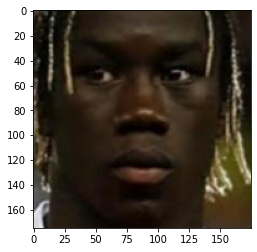

In [9]:
print(dataframe['Ages'][2])
plt.imshow(dataframe['Images'][2])
plt.show()

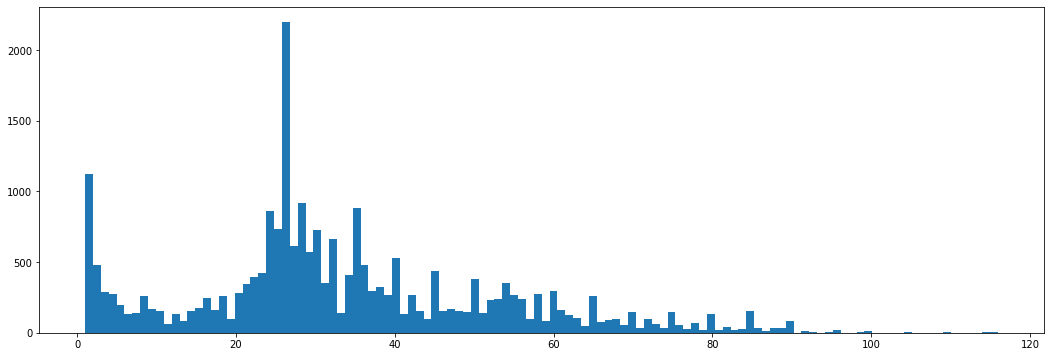

In [10]:
plt.figure(figsize=(18,6))
plt.hist(dataframe['Ages'],bins=dataframe['Ages'].max())
plt.show()

In [11]:
under_30 = dataframe[(dataframe['Ages']>= 20)&(dataframe['Ages']< 30)]
under_30_new = under_30.sample(frac=0.15)  

up_30  = dataframe[dataframe['Ages']>30]

dataframe = pd.concat([under_30_new,up_30],axis=0)

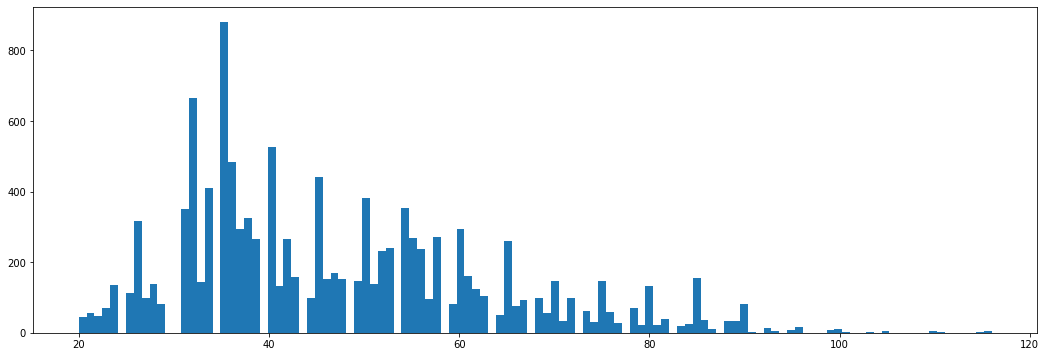

In [12]:
plt.figure(figsize=(18,6))
plt.hist(dataframe['Ages'],bins=dataframe['Ages'].max())
plt.show()

In [13]:
dataframe = dataframe[dataframe['Ages'] < 80]

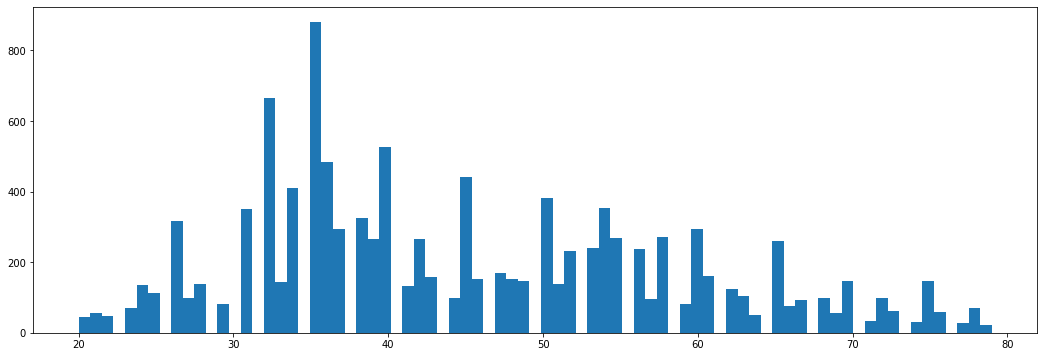

In [14]:
plt.figure(figsize=(18,6))
plt.hist(dataframe['Ages'],bins=dataframe['Ages'].max())
plt.show()

In [15]:
X = np.array(dataframe['Images'].values.tolist())
Y = np.array(dataframe['Ages'].values.tolist())

print(X.shape)
Y.shape

(11476, 175, 175, 3)


(11476,)

In [16]:
X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size=0.2)

print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(9180, 175, 175, 3)
(2296, 175, 175, 3)
(9180,)
(2296,)


In [17]:
idg = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
)

train_data = idg.flow(X_train,Y_train,batch_size=batch_size)
val_data = idg.flow(X_val,Y_val,batch_size=batch_size)

### Train

In [18]:
base_model = tf.keras.applications.InceptionResNetV2(
    input_shape=(width,height,3),
    weights='imagenet',
    include_top=False,
    pooling='avg'

)

219070464/219055592 [==============================] - 1s 0us/step


In [19]:
for layer in base_model.layers[:-4]:
  layer.trainable=False

In [32]:
model = tf.keras.Sequential([
                             base_model,
                             Dropout(0.5),
                             Dense(1024,activation='relu'),
                             Dense(512,activation='relu'),
                             Dense(1)
])

In [34]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss=tf.keras.losses.mae)

In [35]:
model.fit(train_data,validation_data=val_data,epochs=20,shuffle=True)

Epoch 1/20
287/287 [==============================] - 57s 166ms/step - loss: 8.1304 - val_loss: 7.3530
Epoch 2/20
287/287 [==============================] - 44s 154ms/step - loss: 6.4126 - val_loss: 7.8779
Epoch 3/20
287/287 [==============================] - 44s 154ms/step - loss: 5.7739 - val_loss: 7.4062
Epoch 4/20
287/287 [==============================] - 44s 154ms/step - loss: 5.8669 - val_loss: 7.1055
Epoch 5/20
287/287 [==============================] - 44s 154ms/step - loss: 5.6876 - val_loss: 7.2602
Epoch 6/20
287/287 [==============================] - 44s 154ms/step - loss: 5.3509 - val_loss: 7.5522
Epoch 7/20
287/287 [==============================] - 44s 154ms/step - loss: 5.2147 - val_loss: 7.2841
Epoch 8/20
287/287 [==============================] - 44s 154ms/step - loss: 5.1815 - val_loss: 7.8039
Epoch 9/20
287/287 [==============================] - 44s 154ms/step - loss: 5.1083 - val_loss: 7.0692
Epoch 10/20
287/287 [==============================] - 44s 154ms/step - l

array([[32.116608]], dtype=float32)

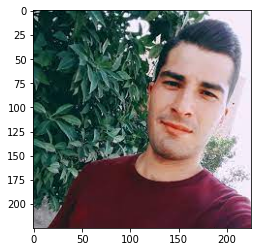

In [39]:
image = cv2.imread('/content/download (29).jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

img = cv2.resize(image,(width,height))
img = img / 255.0

img = img.reshape(1,width,height,3)

result = model.predict(img)
result